In [1]:
# Use "SVD" to predict user rating of each movie

In [2]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
from tensorflow.contrib import learn
import re
import itertools
from collections import Counter
from collections import defaultdict
import gzip
import struct
import smtplib
from email.mime.text import MIMEText
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
basedir = '/home/tvromen/research/subtitles'

class Flags(object):
    def __init__(self):
        # Data loading params
        self.val_sample_percentage = .1 # Percentage of the training data to use for validation
        self.ratings_file = os.path.join(basedir, 'ml-20m/ratings-subset.csv') # Data source for the ratings
        self.text_data_file = os.path.join(basedir, 'movielens-subtitles-1024.txt') # Data source

        self.max_lines = 5000000

        # Model Hyperparameters
        self.embedding_dim = 64 # Dimensionality of user & movie vectors (default: 128)

        #self.max_vocab_size = 100000
        #self.vocab_embedding_dim = 300 # Dimensionality of character embedding (default: 128)
        #self.filter_sizes = "3,4,5" # Comma-separated filter sizes (default: '3,4,5')
        #self.num_filters = 128 # Number of filters per filter size (default: 128)
        #self.dropout_keep_prob = 0.5 # Dropout keep probability (default: 0.5)

        #self.words_in_scene = 64
        #self.num_scenes = 16

        # Training parameters
        self.batch_size = 128 # Batch Size (default: 128)
        self.num_epochs = 10 # Number of training epochs (default: 8)
        self.summary_every = 100
        self.evaluate_every = 1000 # Evaluate model on val set after this many steps (default: 100)
        self.checkpoint_every = 2000 # Save model after this many steps (default: 100)
        self.num_checkpoints = 3 # Number of checkpoints to store (default: 5)
        # Misc Parameters
        self.allow_soft_placement = True # Allow device soft device placement
        self.log_device_placement = True # Log placement of ops on devices

FLAGS = Flags()

In [7]:
# Data helpers

class IdAssigner:
    def __init__(self):
        self.forward = dict()
        self.reverse = dict()
        self.next_id = 0
    def get_id(self, x):
        if x not in self.forward:
            self.forward[x] = self.next_id
            self.reverse[self.next_id] = x
            self.next_id += 1
        return self.forward[x]
    def get_reverse_id(self, id_):
        return self.reverse[id_]
    def get_next_id(self):
        return self.next_id

class Subtitles:
    """
    Class that is in charge of subtitles
    """
    def __init__(self, data_file):
        samples = list(open(data_file, 'r').readlines())
        samples = [s.strip() for s in samples]
        ids = [int(s.split()[0]) for s in samples]
        x_text = [' '.join(s.split()[1:]) for s in samples]
        self.subs = dict()
        for id_,txt in zip(ids, x_text):
            self.subs[id_] = txt


class RatingsData:
    """
    Loads the ratings from the file. Returns an array x where each row is [user_id, movie_id]
    The movie_id is not the original movie_id, but rather a new id which is allocated densely (no skips)
    Only movies with rating >= 3.0 are considered watched (TODO)
    """

    def __init__(self, data_file, max_lines, subs):
        self.id_assigner = IdAssigner()
        self.movies_per_user = defaultdict(list) # map user_id -> [movie_id_1, movie_id_2, ...]
        self.movie_watch_count = defaultdict(int)   # number of times watched per new_movie_id
        # load file
        x = self._load_file(data_file, max_lines, subs)
        x = self._sort_dataset(x)
        x = x[['user_id', 'movie_id', 'rating']]
        # split training/validation:
        # the training set is all movies for each user except the last (in chronological order)
        # validation set is the last movie for each user
        user_ids = x['user_id']
        is_last = (user_ids != np.append(user_ids[1:], -1))
        self.train = x[~is_last]
        self.val = x[is_last]

    def _load_file(self, data_file, max_lines, subs):
        print("Loading data...")
        x = np.zeros(
            max_lines,
            dtype=[('valid',np.bool), ('user_id',np.int32), ('movie_id', np.int32), ('rating', np.float32), ('timestamp', np.int32)]
        )
        with open(data_file) as f:
            _ = f.readline() # skip first line
            for i,line in enumerate(f.readlines()):
                if i % 1000000 == 0:
                    print('{}...'.format(i))
                if i == max_lines:
                    break
                words = line.split(',')
                user_id  = int(words[0])
                movie_id = int(words[1])
                rating   = float(words[2])
                timestamp = int(words[3])
                #if rating < 3.0:
                #    # we count this as not-watched (for now...)
                #    continue
                if movie_id not in subs.subs:
                    # movie doesn't have subtitles
                    continue
                new_movie_id = self.id_assigner.get_id(movie_id)
                x[i] = (True, user_id, new_movie_id, rating, timestamp)
                self.movies_per_user[user_id].append(new_movie_id)
                self.movie_watch_count[new_movie_id] += 1
        valid = (x['valid'] != 0)
        x = x[valid]
        # center the ratings around 0
        x['rating'] = x['rating'] - np.mean(x['rating'])
        return x[['user_id', 'movie_id', 'rating', 'timestamp']]

    def _sort_dataset(self, x):
        # sort by user and timestamp - use stable sorting algorithm
        x = x[x['timestamp'].argsort(kind='mergesort')]  # secondary sort key
        x = x[x['user_id'].argsort(kind='mergesort')]  # primary sort key
        return x

    def get_num_users(self):
        return max(self.movies_per_user.keys()) + 1 # starts from 1

    def get_num_movies(self):
        return self.id_assigner.get_next_id()

    def get_train(self, shuffle=True):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(len(self.train)))
            return self.train[shuffle_indices]
        else:
            return self.train

    def get_val(self, shuffle=True):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(len(self.val)))
            return self.val[shuffle_indices]
        else:
            return self.val

    def batch_iter(self, x, batch_size, num_epochs, shuffle=True):
        """
        Generates the pair for each datapoint, and then
        generates a batch iterator.
        """
        assert type(x) == np.ndarray, type(x)
        data_size = len(x)
        # split to batches
        num_batches_per_epoch = ((data_size - 1) // batch_size) + 1
        for epoch in range(num_epochs):
            # Shuffle the data
            shuffle_indices = np.arange(data_size)
            if shuffle:
                shuffle_indices = np.random.permutation(shuffle_indices)
            x_shuffled = x[shuffle_indices]
            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                end_index = min((batch_num + 1) * batch_size, data_size)
                x_batch = x[start_index:end_index]
                batch_user_id = x_batch['user_id']
                batch_movie_id = x_batch['movie_id']
                batch_rating = x_batch['rating']
                yield (batch_user_id, batch_movie_id, batch_rating)


In [8]:
# Data Preparation
# ==================================================

# Load data
subs = Subtitles(FLAGS.text_data_file)
ratings = RatingsData(FLAGS.ratings_file, FLAGS.max_lines, subs)

np.random.seed(1234)

x_train = ratings.get_train(shuffle=False)
x_val = ratings.get_val(shuffle=False)

print("Train/Val split: {:d}/{:d}".format(len(x_train), len(x_val)))

num_users = ratings.get_num_users()
num_movies = ratings.get_num_movies()

print('Num users: {}'.format(num_users))
print('Num movies: {}'.format(num_movies))

Loading data...
0...
1000000...
2000000...
Train/Val split: 1828055/138488
Num users: 138494
Num movies: 14475


In [9]:
def get_dynamic_tensor_shape(x):
    """
    Calculate the tensor shape. Use a plain number where possible and a tensor elsewhere.
    x is a tensor of some shape.
    returns a list with the dimensions of x.
    """
    shape_tensor = tf.shape(x)
    shape = list(x.get_shape())
    for i in range(len(shape)):
        shape[i] = shape[i].value
        if shape[i] is None:
            # use tensor to represent the dimension
            shape[i] = shape_tensor[i]
    return shape


def embedding_lookup_layer(x, vocab_size, embedding_dim, variable_scope, reuse=False):
    """
    Lookup embedding
    x is tensor of shape (d_1, d_2, ..., d_n) and type int32
    result is tensor of shape (d_1, d_2, ..., d_n, embedding_dim) of n+1 dimensions and type DT_FLOAT
    """
    with tf.variable_scope(variable_scope, reuse=reuse):
        W = tf.get_variable(
            'W',
            shape=[vocab_size, embedding_dim],
            initializer=tf.contrib.layers.xavier_initializer(),
            regularizer=tf.contrib.layers.l2_regularizer(1.)
        )
    x_embedded = tf.nn.embedding_lookup(W, x)
    return x_embedded

def bias_lookup_layer(x, vocab_size, variable_scope, reuse=False):
    """
    Lookup embedding
    x is tensor of shape (d_1, d_2, ..., d_n) and type int32
    result is tensor of same shape in x and type DT_FLOAT
    """
    with tf.variable_scope(variable_scope, reuse=reuse):
        b = tf.get_variable(
            'b',
            shape=[vocab_size, 1],
            initializer=tf.zeros_initializer(),
            regularizer=tf.contrib.layers.l2_regularizer(1.)
        )
    x_bias = tf.squeeze(tf.nn.embedding_lookup(b, x), -1)
    return x_bias

def fc_layer(x, output_size, variable_scope, reuse=False):
    """
    Fully-connected layer
    x has shape (batch_size, d_2)
    result has shape (batch_size, output_size)
    """
    shape = get_dynamic_tensor_shape(x)
    assert len(shape) == 2
    ## TODO: regularization
    with tf.variable_scope(variable_scope, reuse=reuse):
        W = tf.get_variable(
            "W",
            shape=[shape[1], output_size],
            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(
            "b",
            shape=[output_size],
            initializer=tf.contrib.layers.xavier_initializer())
    result = tf.nn.xw_plus_b(x, W, b, name="fc")
    return result


class PredictionModel(object):
    """
    A neural network for predicting per-user movie ratings.
    The input to the network is the user_id and movie_id.
    """
    def __init__(self, num_users, num_movies, embedding_dim, l2_reg_lambda):

        assert num_users >= 1
        self.num_users = num_users
        assert num_movies >= 1
        self.num_movies = num_movies
        assert embedding_dim >= 1
        self.embedding_dim = embedding_dim
        assert l2_reg_lambda >= 0

        # Placeholders for input, output and dropout
        self.input_user_id = tf.placeholder(tf.int32, [None], name="input_user_id")
        self.input_movie_id = tf.placeholder(tf.int32, [None], name="input_movie_id")
        self.input_rating = tf.placeholder(tf.float32, [None], name="input_rating")
        #self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob") # TODO: do we need dropout?

        asrt1 = tf.assert_equal(tf.shape(self.input_user_id)[0], tf.shape(self.input_movie_id)[0])
        asrt2 = tf.assert_equal(tf.shape(self.input_user_id)[0], tf.shape(self.input_rating)[0])

        # embedding lookup layer
        with tf.device('/cpu:0'), tf.name_scope('embedding_lookup'), tf.control_dependencies([asrt1]):
            user_embedding = embedding_lookup_layer(self.input_user_id, self.num_users, self.embedding_dim, 'user_embedding')
            user_bias = bias_lookup_layer(self.input_user_id, self.num_users, 'user_embedding')
            movie_embedding = embedding_lookup_layer(self.input_movie_id, self.num_movies, self.embedding_dim, 'movie_embedding')
            movie_bias = bias_lookup_layer(self.input_movie_id, self.num_movies, 'movie_embedding')
            #user_embedding_fc = fc_layer(user_embedding, self.embedding_dim, 'embedding_fc', reuse=None)
            #movie_embedding_fc = fc_layer(movie_embedding, self.embedding_dim, 'embedding_fc', reuse=True)
            self.rating_prediction = tf.reduce_sum(user_embedding * movie_embedding, axis=1) + user_bias + movie_bias

        with tf.name_scope('rating_loss'):
            losses = tf.square(self.input_rating - self.rating_prediction)
            self.rating_loss = tf.reduce_mean(losses)

        with tf.name_scope('loss'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            self.loss = self.rating_loss + l2_reg_lambda * sum(reg_losses)

        # Rating accuracy = RMSE (for now...)
        # (this is actually error rate, and not accuracy, i.e. lower is better)
        with tf.name_scope('rating_accuracy'):
            self.rating_accuracy = tf.sqrt(self.rating_loss)

    def get_predictions(self):
        asrt1 = tf.assert_equal(tf.shape(self.input_user_id)[0], 1)
        with tf.device('/cpu:0'), tf.name_scope('embedding_lookup'), tf.control_dependencies([asrt1]):
            user_embedding = embedding_lookup_layer(self.input_user_id, self.num_users, self.embedding_dim, 'user_embedding', True)
            user_bias = bias_lookup_layer(self.input_user_id, self.num_users, 'user_embedding', True)
            movie_embedding = embedding_lookup_layer(self.input_movie_id, self.num_movies, self.embedding_dim, 'movie_embedding', True)
            movie_bias = bias_lookup_layer(self.input_movie_id, self.num_movies, 'movie_embedding', True)
            prediction = tf.reduce_sum(user_embedding * movie_embedding, axis=1) + user_bias + movie_bias
            self.tmp1 = tf.reduce_sum(user_embedding * movie_embedding, axis=1)
            self.tmp2 = user_bias
            self.tmp3 = movie_bias
            return prediction


In [10]:
# Training
# ==================================================

def train(
    cnn, sess, starter_learning_rate, learning_rate_decay_every, learning_rate_decay_by
):
    last_accuracy = 0

    # Define Training procedure
    global_step = tf.Variable(0, name="global_step", trainable=False)
    #optimizer = tf.train.AdamOptimizer(1e-3)
    learning_rate = tf.train.exponential_decay(
        starter_learning_rate, global_step, learning_rate_decay_every,
        learning_rate_decay_by, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)

    grads_and_vars = optimizer.compute_gradients(cnn.loss)
    train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

    # Keep track of gradient values and sparsity (optional)
    grad_summaries = []
    #for g, v in grads_and_vars:
    for g,v in []:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    #grad_summaries_merged = tf.summary.merge(grad_summaries)

    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))

    # Summaries for loss and accuracy
    rating_loss_summary = tf.summary.scalar("rating_loss", cnn.rating_loss)
    loss_summary = tf.summary.scalar("loss", cnn.loss)
    acc_summary = tf.summary.scalar("accuracy", cnn.rating_accuracy)
    learning_rate_summary = tf.summary.scalar("learning_rate", learning_rate)

    # Train Summaries
    train_summary_op = tf.summary.merge([rating_loss_summary, loss_summary, acc_summary, learning_rate_summary])#, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Val summaries
    val_summary_op = tf.summary.merge([rating_loss_summary, loss_summary, acc_summary, learning_rate_summary])
    val_summary_dir = os.path.join(out_dir, "summaries", "val")
    val_summary_writer = tf.summary.FileWriter(val_summary_dir, sess.graph)

    # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
    checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
    checkpoint_prefix = os.path.join(checkpoint_dir, "model")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

    # Initialize all variables
    sess.run(tf.global_variables_initializer())

    def train_step(batch_user_id, batch_movie_id, batch_rating):
        """
        A single training step 
        """
        feed_dict = {
            cnn.input_user_id: batch_user_id,
            cnn.input_movie_id: batch_movie_id,
            cnn.input_rating: batch_rating
        }
        (pretrain_rating_accuracy,) = sess.run([cnn.rating_accuracy], feed_dict)
        sess.run(train_op, feed_dict)
        step, loss, rating_accuracy, rate = sess.run(
            [global_step, cnn.loss, cnn.rating_accuracy, learning_rate],
            feed_dict)
        if step % FLAGS.summary_every == 0:
            summaries = sess.run(train_summary_op, feed_dict)
            train_summary_writer.add_summary(summaries, step)
        time_str = datetime.datetime.now().isoformat()
        if step % FLAGS.summary_every == 0:
            print("{}: step {}, loss {:g}, rating_acc {:g}->{:g}, rate {:g}".format(
                time_str, step, loss, pretrain_rating_accuracy, rating_accuracy, rate))
        return rating_accuracy

    def val_step(batch_user_id, batch_movie_id, batch_rating, writer=None):
        """
        Evaluates model on a val set
        """
        feed_dict = {
            cnn.input_user_id: batch_user_id,
            cnn.input_movie_id: batch_movie_id,
            cnn.input_rating: batch_rating
        }
        step, summaries, loss, rating_accuracy = sess.run(
            [global_step, val_summary_op, cnn.loss, cnn.rating_accuracy],
            feed_dict)
        time_str = datetime.datetime.now().isoformat()
        print("{}: step {}, loss {:g}, rating_acc {:g}".format(
            time_str, step, loss, rating_accuracy))
        if writer:
            writer.add_summary(summaries, step)
        return rating_accuracy

    # Generate batches
    batches = ratings.batch_iter(x_train, FLAGS.batch_size, FLAGS.num_epochs)
    # Training loop. For each batch...
    last_test_rating_accuracy = None
    for batch_user_id, batch_movie_id, batch_rating in batches:
        last_rating_accuracy = train_step(batch_user_id, batch_movie_id, batch_rating)
        current_step = tf.train.global_step(sess, global_step)
        if current_step % FLAGS.evaluate_every == 0:
            print("\nEvaluation:")
            ((val_user_id, val_movie_id, val_rating),) = ratings.batch_iter(x_val, len(x_val), 1)
            if len(x_val) > 1024:
                val_user_id, val_movie_id, val_rating = val_user_id[:1024], val_movie_id[:1024], val_rating[:1024]
            last_test_rating_accuracy = \
                val_step(val_user_id, val_movie_id, val_rating, writer=val_summary_writer)
            print("")
        if current_step % FLAGS.checkpoint_every == 0:
            path = saver.save(sess, checkpoint_prefix, global_step=current_step)
            print("Saved model checkpoint to {}\n".format(path))
            pass
    return (last_rating_accuracy, last_test_rating_accuracy)


In [11]:
def calc_precision(model, sess):
    ranks = []
    mrr = 0
    precision_at_10 = 0
    n = 50 # calculate only on first n users in validation set
    for i in range(n):
        user_id, movie_id, rating = x_val[i]
        if i % 50 == 0:
            print('{}...'.format(i))
        num_movies = ratings.id_assigner.get_next_id()
        batch_movie_id = np.arange(num_movies)
        #batch_user_id = np.ones_like(batch_movie_id) * user_id
        #batch_rating = np.zeros_like(batch_movie_id)
        feed_dict = {
            model.input_user_id: [user_id],
            model.input_movie_id: batch_movie_id,
        }
        scores = sess.run(model.get_predictions(), feed_dict=feed_dict)
        #print(scores)
#         tmp1, tmp2, tmp3 = sess.run([model.tmp1, model.tmp2, model.tmp3], feed_dict=feed_dict)
#         print(tmp1)
#         print(tmp2)
#         print(tmp3)
        s = scores[movie_id] # the score for the correct movie
        #print(s)
        train_movies = x_train[x_train['user_id'] == user_id]['movie_id']
        not_watched = (scores == scores) # all True
        not_watched[train_movies] = False
        higher_scores = (scores > s)    
        rank = np.sum(higher_scores & not_watched) + 1
        ranks.append(rank)
        #print('for user_id {} the rank is {}'.format(user_id, rank))
        mrr += 1. / rank
        if rank <= 10:
            precision_at_10 += 1
    mrr /= n
    precision_at_10 /= n
    print('MRR is {}'.format(mrr))
    print('Precision@10 is {}'.format(precision_at_10))
    plt.hist(ranks, bins=np.logspace(0., np.log10(ratings.id_assigner.get_next_id()) , 20), normed=1)
    plt.gca().set_xscale("log")
    plt.show()
    return mrr, precision_at_10

In [12]:
def runall():
    res = defaultdict(list)
    with open('results.txt', 'a') as f:
        for l2_reg_lambda in [5e-6]:
            with tf.Graph().as_default():
                session_conf = tf.ConfigProto(
                    allow_soft_placement=FLAGS.allow_soft_placement,
                    log_device_placement=FLAGS.log_device_placement)
                session_conf.gpu_options.allow_growth=True
                sess = tf.Session(config=session_conf)
                with sess.as_default():
                    model = PredictionModel(
                        num_users=num_users,
                        num_movies=num_movies,
                        embedding_dim=FLAGS.embedding_dim,
                        l2_reg_lambda=l2_reg_lambda)
                    for i in range(1):
                        f.write('lambda: {}\n'.format(l2_reg_lambda))
                        last_accuracy = train(model, sess, 3e-3, 20000, 0.5)
                        f.write('accuracy: {}\n'.format(last_accuracy))
                        res[l2_reg_lambda].append(last_accuracy)
                        mrr, precision_at_10 = calc_precision(model, sess)
                        f.write(repr((mrr, precision_at_10)) + '\n')
                        f.write('\n')
                        f.flush()
                        
    return res

Writing to /home/tvromen/research/subtitles2/runs/1510214570

2017-11-09T10:02:59.849474: step 100, loss 1.12603, rating_acc 1.06388->1.06106, rate 0.003
2017-11-09T10:03:08.352992: step 200, loss 0.764602, rating_acc 0.878718->0.874156, rate 0.003
2017-11-09T10:03:17.031576: step 300, loss 1.17206, rating_acc 1.08612->1.08222, rate 0.003
2017-11-09T10:03:25.705044: step 400, loss 2.10323, rating_acc 1.45854->1.44979, rate 0.003
2017-11-09T10:03:34.274683: step 500, loss 1.0084, rating_acc 1.01086->1.00319, rate 0.003
2017-11-09T10:03:42.784671: step 600, loss 1.05161, rating_acc 1.03061->1.02428, rate 0.003
2017-11-09T10:03:51.311331: step 700, loss 1.35685, rating_acc 1.17121->1.16355, rate 0.003
2017-11-09T10:03:59.801075: step 800, loss 0.727014, rating_acc 0.858377->0.850423, rate 0.003
2017-11-09T10:04:08.362340: step 900, loss 0.861561, rating_acc 0.936002->0.925767, rate 0.003
2017-11-09T10:04:16.862980: step 1000, loss 1.09663, rating_acc 1.05485->1.04466, rate 0.003

Evaluati

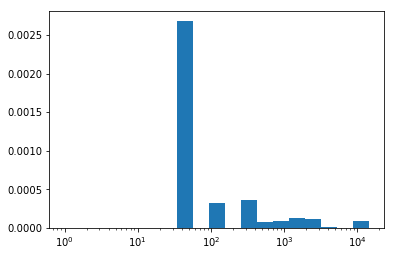

In [13]:
res = runall()

In [14]:
print(datetime.datetime.now().isoformat())

2017-11-09T13:24:44.495162


In [15]:
# 1M lines
# all star ratings are considered watched
# centered the rating data around 0
# lambda = 5e-6
# 10 epochs
res

defaultdict(list, {5e-06: [(0.93820268, 0.97085321)]})

Writing to /home/tvromen/research/subtitles2/runs/1510229502

2017-11-09T14:11:53.172466: step 100, loss 1.12587, rating_acc 1.06387->1.06098, rate 0.003
2017-11-09T14:12:02.905242: step 200, loss 0.764641, rating_acc 0.87873->0.874178, rate 0.003
2017-11-09T14:12:12.604131: step 300, loss 1.17198, rating_acc 1.08611->1.08219, rate 0.003
2017-11-09T14:12:21.199991: step 400, loss 2.10283, rating_acc 1.45846->1.44965, rate 0.003
2017-11-09T14:12:29.354383: step 500, loss 1.00838, rating_acc 1.01088->1.00318, rate 0.003
2017-11-09T14:12:37.415357: step 600, loss 1.05213, rating_acc 1.03068->1.02453, rate 0.003
2017-11-09T14:12:45.477492: step 700, loss 1.3572, rating_acc 1.17127->1.1637, rate 0.003
2017-11-09T14:12:53.570214: step 800, loss 0.726927, rating_acc 0.858337->0.850368, rate 0.003
2017-11-09T14:13:01.634919: step 900, loss 0.861237, rating_acc 0.935853->0.925591, rate 0.003
2017-11-09T14:13:09.647892: step 1000, loss 1.09808, rating_acc 1.05535->1.04535, rate 0.003

Evaluation

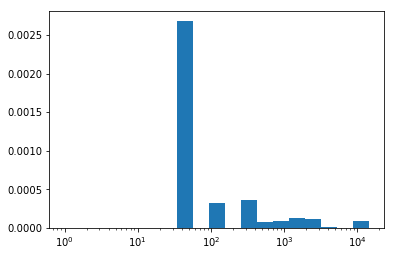

In [16]:
l2_reg_lambda = 5e-6
tf.Graph().as_default()
session_conf = tf.ConfigProto(
    allow_soft_placement=FLAGS.allow_soft_placement,
    log_device_placement=FLAGS.log_device_placement)
session_conf.gpu_options.allow_growth=True
sess = tf.Session(config=session_conf)
sess.as_default()
model = PredictionModel(
    num_users=num_users,
    num_movies=num_movies,
    embedding_dim=FLAGS.embedding_dim,
    l2_reg_lambda=l2_reg_lambda)
last_accuracy = train(model, sess, 3e-3, 20000, 0.5)
mrr, precision_at_10 = calc_precision(model, sess)


In [17]:
ranks = []
mrr = 0
precision_at_10 = 0
n = 500 # calculate only on first n users in validation set
for i in range(n):
    user_id, movie_id, rating = x_val[i]
    if i % 50 == 0:
        print('{}...'.format(i))
    num_movies = ratings.id_assigner.get_next_id()
    batch_movie_id = np.arange(num_movies)
    #batch_user_id = np.ones_like(batch_movie_id) * user_id
    #batch_rating = np.zeros_like(batch_movie_id)
    feed_dict = {
        model.input_user_id: [user_id],
        model.input_movie_id: batch_movie_id,
    }
    scores = sess.run(model.get_predictions(), feed_dict=feed_dict)
    #print(scores)
#         tmp1, tmp2, tmp3 = sess.run([model.tmp1, model.tmp2, model.tmp3], feed_dict=feed_dict)
#         print(tmp1)
#         print(tmp2)
#         print(tmp3)
    s = scores[movie_id] # the score for the correct movie
    #print(s)
    train_movies = x_train[x_train['user_id'] == user_id]['movie_id']
    not_watched = (scores == scores) # all True
    not_watched[train_movies] = False
    higher_scores = (scores > s)    
    rank = np.sum(higher_scores & not_watched) + 1
    ranks.append(rank)
    #print('for user_id {} the rank is {}'.format(user_id, rank))
    mrr += 1. / rank
    if rank <= 10:
        precision_at_10 += 1
    print(rank)
mrr /= n
precision_at_10 /= n
print(mrr)
print(precision_at_10)

0...
13999
14375
14141
9008
411
10321
2852
11709
14256
11006
901
1830
12813
4509
3523
372
12325
149
11600
2411
9872
1860
10803
11567
1308
11437
12211
10871
13449
12106
1954
416
12114
13064
9549
12436
2284
10870
536
1059
2085
49
2123
47
1196
12735
13467
2356
37
1859
50...
14068
2575
1996
13022
100
13766
11600
9221
2
1916
10991
9511
2850
11469
494
335
732
12992
682
12232
9
11132
1381
709
12518
323
261
2307
10617
3379
12210
2408
1712
444
332
1117
90
13335
12629
1085
763
3775
3025
12714
2124
253
10872
1413
169
550
100...
9260
496
1047
1857
7961
596
3931
12895
601
40
12047
2353
14047
4398
1
12250
2078
573
14227
10719
2703
2061
423
12674
10827
13519
13874
2619
12026
13380
9078
2478
11896
12946
1214
13153
1743
2214
11775
207
954
12891
10454
196
256
2563
13408
2575
11533
2101
150...
10148
11791
749
828
12268
9380
8562
10721
12425
10320
13685
1622
10429
12625
3126
265
325
2755
62
2574
2830
1096
8630
87
3262
491
1580
2342
1002
10927
8662
13522
12543
1
783
904
3330
1957
57
4
12945
2048
176
1832
1

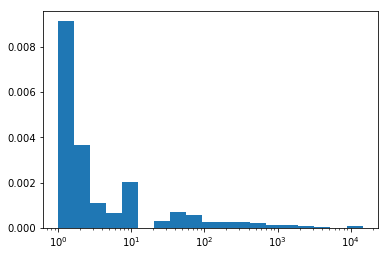

In [18]:
plt.hist(ranks, bins=np.logspace(0., np.log10(ratings.id_assigner.get_next_id()) , 20), normed=1)
plt.gca().set_xscale("log")
plt.show()

In [19]:
for k in range(1, 11):
    print(np.sum([r <= k for r in ranks]))

3
5
5
6
6
6
7
8
10
12


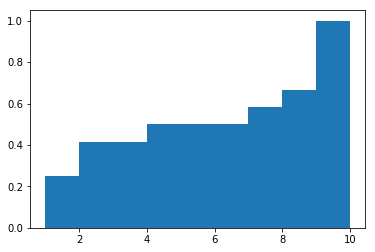

In [20]:
plt.hist(ranks, bins=np.arange(1, 11), normed=1, cumulative=True)
plt.show()

In [21]:
ranks_backup = ranks

In [22]:
# MRR@10
mrr10 = np.mean([(1./r if r <= 10 else 0) for r in ranks_backup])
print(mrr10)

0.00988015873016


In [23]:
# try a naive model - movie bias only

total_watches = np.bincount(x_train['movie_id'])
mean_rating = np.zeros(total_watches.shape)
for i in range(ratings.id_assigner.get_next_id()):
    if i % 500 == 0:
        print('{}...'.format(i))
    t = x_train[x_train['movie_id'] == i]['rating']
    if len(t) > 0:
        mean_rating[i] = np.mean(t)


0...
500...
1000...
1500...
2000...
2500...
3000...
3500...
4000...
4500...
5000...
5500...
6000...
6500...
7000...
7500...
8000...
8500...
9000...
9500...
10000...
10500...
11000...
11500...
12000...
12500...
13000...
13500...
14000...


In [24]:
# RMSE for the naive model

rmse = 0.
n = 500 # calculate only on first n users in validation set
for i in range(n):
    user_id, movie_id, rating = x_val[i]
    if i % 50 == 0:
        print('{}...'.format(i))
    rmse += (rating - mean_rating[movie_id])**2
rmse /= n
rmse = np.sqrt(rmse)
print(rmse)

0...
50...
100...
150...
200...
250...
300...
350...
400...
450...
0.940578829937


0...
2921
3037
1036
334
141
392
1701
580
1072
633
3021
19
125
134
200
2
1600
2855
3414
124
297
383
1185
886
3637
1856
386
52
3134
606
22
115
828
818
2846
449
276
51
157
251
737
352
73
21
4395
266
82
2744
313
155
50...
923
5
241
545
50
3448
472
1527
31
392
2533
415
319
83
2417
753
642
853
204
53
1275
279
1711
719
99
50
404
1591
3891
128
1584
5566
195
12
917
353
3
967
816
126
436
910
456
3993
966
25
52
862
98
780
100...
3029
2029
109
128
677
430
3229
1908
354
28
2436
700
2655
7683
4
3107
1004
71
464
971
555
622
172
2543
297
2046
398
794
234
394
2636
2205
1573
2202
1689
3516
1597
687
1024
80
982
796
571
935
7
578
2154
5
1357
204
150...
300
95
156
1121
3064
301
517
642
4105
522
2395
32
201
2734
279
1236
269
2310
16
5
480
208
646
414
203
47
300
104
49
538
1823
2048
2846
4
2059
412
650
23
8
20
3017
425
149
1594
1776
2484
134
2280
311
3503
200...
1094
187
92
32
685
961
9405
1834
2964
26
894
267
77
94
16
2388
2802
406
594
18
717
1547
55
187
294
417
525
848
682
12
87
926
44
38
1957
36
202
3110


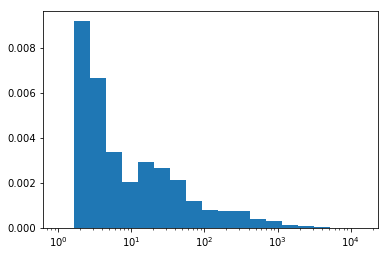

In [25]:
# MRR for the naive model

ranks = []
mrr = 0
precision_at_10 = 0
n = 500 # calculate only on first n users in validation set
for i in range(n):
    user_id, movie_id, rating = x_val[i]
    if i % 50 == 0:
        print('{}...'.format(i))
    scores = total_watches
    s = scores[movie_id] # the score for the correct movie
    train_movies = x_train[x_train['user_id'] == user_id]['movie_id']
    not_watched = (scores == scores) # all True
    not_watched[train_movies] = False
    higher_scores = (scores > s)    
    rank = np.sum(higher_scores & not_watched) + 1
    ranks.append(rank)
    mrr += 1. / rank
    if rank <= 10:
        precision_at_10 += 1
    print(rank)
mrr /= n
precision_at_10 /= n
print(mrr)
print(precision_at_10)
plt.hist(ranks, bins=np.logspace(0., np.log10(ratings.id_assigner.get_next_id()) , 20), normed=1)
plt.gca().set_xscale("log")
plt.show()

In [26]:
for k in range(1, 11):
    print(np.sum([r <= k for r in ranks]))

0
5
8
11
14
15
16
17
18
18


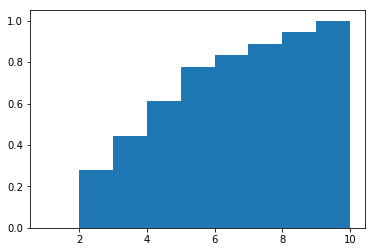

In [27]:
plt.hist(ranks, bins=np.arange(1, 11), normed=1, cumulative=True)
plt.show()

In [28]:
# MRR@10
mrr10 = np.mean([(1./r if r <= 10 else 0) for r in ranks])
print(mrr10)

0.0107912698413


In [81]:
# 1M lines
# all star ratings are considered watched
# centered the rating data around 0
# lambda = 5e-6
# 10 epochs
res

defaultdict(list, {5e-06: [(0.49899518, 0.88868439)]})

In [76]:
# 1M lines
# all star ratings are considered watched
# added regularization with various lambda values
# centered the rating data around 0
res

defaultdict(list,
            {1e-05: [(0.94917321, 0.90415049)],
             2e-05: [(1.0507183, 0.94094837)],
             5e-05: [(1.1423631, 0.99971867)],
             0.0001: [(1.2070471, 1.0341849)],
             0.0002: [(1.2103031, 1.032499)],
             0.0005: [(1.2117321, 1.031128)],
             0.001: [(1.211888, 1.0307046)]})

In [73]:
# 1M lines
# all star ratings are considered watched
# added regularization with various lambda values
# centered the rating data around 0
res

defaultdict(list,
            {0.0: [(0.37671992, 1.0658302)],
             1e-06: [(0.52806127, 0.92396885)],
             2e-06: [(0.61344689, 0.91350502)],
             5e-06: [(0.79430443, 0.8886568)]})

In [64]:
# 1M lines
# all star ratings are considered watched
# added regularization with various lambda values
res

defaultdict(list,
            {1e-06: [(0.66761941, 0.94619572)],
             5e-06: [(0.86379659, 0.98251671)]})

In [61]:
# 1M lines
# all star ratings are considered watched
# added regularization with various lambda values
res

defaultdict(list,
            {2e-06: [(0.74221069, 0.94485837)],
             2e-05: [(1.0187515, 1.1469429)]})

In [58]:
# 1M lines
# all star ratings are considered watched
# added regularization with various lambda values
res

defaultdict(list,
            {0.0: [(0.39927015, 1.0191419)],
             0.0001: [(1.2529024, 1.5867586)],
             0.0002: [(1.3900354, 1.8572755)],
             0.0005: [(1.6396413, 2.2380252)],
             0.001: [(1.9155307, 2.5586977)],
             0.002: [(2.2482929, 2.8847487)],
             0.005: [(2.6905251, 3.2657373)],
             0.01: [(2.9629481, 3.4821424)],
             0.02: [(3.1559427, 3.6294582)],
             0.05: [(3.3028438, 3.7391768)],
             0.1: [(3.3588696, 3.7807691)]})

In [38]:
# 1M lines
# all star ratings are considered watched
# added regularization (0.01)
res

defaultdict(list, {0: [(2.9629481, 3.4821424)]})

In [33]:
# 1M lines
# all star ratings are considered watched
# added regularization (0.1)
res

defaultdict(list, {0: [(3.3588698, 3.7807691)]})

In [20]:
# 1M lines
# all star ratings are considered watched
res

defaultdict(list, {0: [(0.41014692, 1.0094724)]})